In [54]:
#Import the required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [55]:
%matplotlib inline

In [56]:
!pip install visualkeras

### Dataset Augmentation: Add operating condition history as features

In [57]:
# Takes raw dataset as an input, then performs clustering by operating settings.
# Returns a dataframe with an additional column called operating_condition as output.
def cluster(read_path, sub_dataset):
    print("Clustering for FD{}".format(sub_dataset))
    # Read files:
    train_data = pd.read_csv(read_path+"train_FD"+sub_dataset+".txt", sep = " ", header = None)
    test_data = pd.read_csv(read_path+"test_FD"+sub_dataset+".txt", sep = " ", header = None)

    # Add column names
    trainTestColumns = ['Engine', 'Cycle',
                        'setting1', 'setting2', 'setting3',
                        'Fan Inlet Temperature (◦R)',
                       'LPC Outlet Temperature (◦R)',
                       'HPC Outlet Temperature (◦R)',
                       'LPT Outlet Temperature (◦R)',
                       'Fan Inlet Pressure (psia)',
                       'Bypass-Duct Pressure (psia)',
                       'HPC Outlet Pressure (psia)',
                       'Physical Fan Speed (rpm)',
                       'Physical Core Speed (rpm)',
                       'Engine Pressure Ratio (P50/P2)',
                       'HPC Outlet Static Pressure (psia)',
                       'Ratio of Fuel Flow to Ps30 (pps/psia)',
                       'Corrected Fan Speed (rpm)',
                       'Corrected Core Speed (rpm)', 
                       'Bypass Ratio',
                       'Burner Fuel-Air Ratio',
                       'Bleed Enthalpy',
                       'Required Fan Speed',
                       'Required Fan Conversion Speed',
                       'High-Pressure Turbines Cool Air Flow', 
                       'Low-Pressure Turbines Cool Air Flow',
                       'Sensor 26',
                       'Sensor 27']
    train_data.columns = test_data.columns = trainTestColumns

    # Clustering
    input_kmeans = train_data[["setting1", "setting2", "setting3"]]
    
    estimator=KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=500, tol=0.0001, 
                 verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
    
    estimator.fit(input_kmeans)
    train_data_labels = estimator.labels_
    
    test_data_labels = estimator.predict(test_data[["setting1", "setting2", "setting3"]])

    dx = np.ones(10)
    dy = np.ones(10)
    dz = [0,1,2,3,4,5,6,7,8,9]

    #Visualizing Clusters
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(test_data['setting1'],test_data['setting2'],test_data['setting3'],
               c=test_data_labels.astype(float),cmap='Greens', edgecolor='k', s=150)
    # # ax.w_xaxis.set_ticklabels('setting1')
    # ax.w_yaxis.set_ticklabels('setting2')
    # ax.w_zaxis.set_ticklabels('setting3')
    # ax.w_xaxis.set_ticklabels('setting1')
    ax.set_xlabel('Operating Setting 1')
    ax.set_ylabel('Operating Setting 2')
    ax.set_zlabel('Operating Setting 3')
    
    ax.set_title('FD'+sub_dataset+' Test Data Operating Modes', fontsize=20)
    plt.show()
    plt.savefig('output.png')
    
    #Adding labels column to the main dataframe
    train_data["operating_condition"] = train_data_labels
    test_data["operating_condition"] = test_data_labels
    
    print("Complete Clustering for FD{} and added a column named operating_condition".format(sub_dataset))

    return train_data, test_data

In [58]:
x = [74, 74, 74, 74, 74, 74, 74, 74, 192, 74]
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
z =  [1455, 1219, 1240, 1338, 1276, 1298, 1292, 1157, 486, 1388]
dx = np.ones(10)
dy = np.ones(10)
dz = [0,1,2,3,4,5,6,7,8,9]


fig = plt.figure()
ax = Axes3D(fig)
ax.bar3d(x, y, z, dx, dy, dz, color='#00ceaa')
ax.set_title("Data Analysis ")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


plt.show()

<Figure size 640x480 with 0 Axes>

In [59]:
# Takes dataframe generated by cluster() as input. 
# Calculates history of operating conditions and if save = True generates a new .csv file 
# of the original data plus the six columns indicating operating history.
def oc_history_cols(read_path, sub_dataset, train_data, test_data, save=False):
    
    if "operating_condition" not in train_data.columns or "operating_condition" not in test_data.columns:
        print("Column operating_condition is not found in the data frame")

    else:
        print("Adding History Columns in the Data Frame")
        train_data[["oc_0","oc_1","oc_2","oc_3","oc_4","oc_5"]]= pd.DataFrame([[0,0,0,0,0,0]], index=train_data.index)
        test_data[["oc_0","oc_1","oc_2","oc_3","oc_4","oc_5"]]= pd.DataFrame([[0,0,0,0,0,0]], index=test_data.index)
        
        for file in ["train", "test"]:
            if file == "train":
                groupby_traj = train_data.groupby('Engine', sort=False)
            else:
                groupby_traj = test_data.groupby('Engine', sort=False)
                
            additional_oc=[]
            for Engine, data in groupby_traj:
                data=data.reset_index()
                for i in range(data.shape[0]):
                    check_oc=data.iloc[i]["operating_condition"]
                    if  i != data.shape[0]-1:
                        value = data.iloc[i+1]["oc_"+str(int(check_oc))] + 1
                        for idx in range(i+1, len(data)):
                            data.at[idx, "oc_"+str(int(check_oc))] = value
                        #data.at[i+1:, "oc_"+str(int(check_oc))]=data.iloc[i+1]["oc_"+str(int(check_oc))]+1
                additional_oc.append(data)
            
            oc_cols=pd.concat(additional_oc,  sort=False, ignore_index=False)
            oc_cols=oc_cols.set_index('index', drop=True)
            
            if save:
                print("Saving the {} data with operating condition history columns".format(file))
                oc_cols.to_csv(read_path+file+"_FD"+sub_dataset+"_cluster.csv", index=False)
    return None

In [60]:
read_path = "CMAPSSData/"

In [61]:
# Dataset 001:
train_data, test_data = cluster(read_path, "001")
oc_history_cols(read_path, "001", train_data, test_data, save=True)

Clustering for FD001


<Figure size 640x480 with 0 Axes>

Complete Clustering for FD001 and added a column named operating_condition
Adding History Columns in the Data Frame
Saving the train data with operating condition history columns
Saving the test data with operating condition history columns


<Figure size 640x480 with 0 Axes>

In [17]:
plt.get_backend()  # Check what backend is being used

'module://matplotlib_inline.backend_inline'

In [6]:
# Computes the RUL of engines for the given dataset. 
# Reads true RUL values from the RUl file and calculates RUL using knee_RUL 
# Returns a list of computed RUL values 
def compute_rul(max_life, true_rul_df, data_set, finaltest=False, id='Engine'):
    MAXLIFE = max_life
    rul = []
    true_rul = true_rul_df.iloc[:, 0].tolist()
    #print(true_rul)
    # true_rul.columns = ["RUL"]
    unique_set = pd.unique(data_set['Engine'])
    # print("Length of true_rul['RUL']:", len(true_rul))

    for _id in unique_set :
        #print(_id)
        unique_engine_ID = data_set[data_set['Engine'] == _id]
        cycle_list = unique_engine_ID['Cycle'].tolist()
        
        if finaltest:
            #print("_id - 1:", _id - 1)
            max_cycle = max(cycle_list) + true_rul[_id-1] #_id-1
            #print(max(cycle_list), true_rul[_id-1])
        else:
            max_cycle = max(cycle_list)
        #if max_cycle < MAXLIFE:
        #print('<130 _id {} | max_cycle {}'.format(_id, max_cycle))
        rul.extend(knee_RUL(cycle_list, max_cycle, MAXLIFE))

    data_set["RUL"]=rul
        
    return data_set

In [7]:
# Computes the RUL of engines using a piecewise linear function with zero and unit gradients. 
# Generates a list of RUL values based on the given cycle and life thresholds. 
def knee_RUL(cycle_list, max_cycle, MAXLIFE):
    '''
    Piecewise linear function with zero gradient and unit gradient
            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    knee_RUL = []
    if max_cycle >= MAXLIFE:
        knee_point = max_cycle - MAXLIFE
        
        for i in range(0, len(cycle_list)):
            if i < knee_point:
                knee_RUL.append(MAXLIFE)
            else:
                #print(knee_point)
                #print(knee_RUL)
                tmp = knee_RUL[i - 1] - (MAXLIFE / (max_cycle - knee_point))
                knee_RUL.append(tmp)
    else:
        knee_point = MAXLIFE
        print("=========== knee_point < MAXLIFE ===========")
        for i in range(0, len(cycle_list)):
            knee_point -= 1
            knee_RUL.append(knee_point)
            
    return knee_RUL

In [8]:
rul_doc = pd.read_csv('CMAPSSData/RUL_FD001.txt', header=None)
train_data = compute_rul(max_life=125, 
                       true_rul_df=rul_doc,  
                       data_set = train_data,  
                       finaltest=False)
test_data = compute_rul(max_life=125, 
                       true_rul_df=rul_doc,  
                       data_set = test_data,  
                       finaltest=True)

In [9]:
train_data

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,Sensor 26,Sensor 27,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,1,0,0,0,0,0,0,125.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,3,0,0,0,0,0,0,125.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,2,0,0,0,0,0,0,125.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,4,0,0,0,0,0,0,125.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,5,0,0,0,0,0,0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,1,0,0,0,0,0,0,4.0
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,5,0,0,0,0,0,0,3.0
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,4,0,0,0,0,0,0,2.0
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,1,0,0,0,0,0,0,1.0


In [10]:
train_data.describe()

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,Sensor 26,Sensor 27,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0,20631.000000,20631.0,20631.0,20631.0,20631.0,20631.0,20631.0,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.3,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN,2.774223,0.0,0.0,0.0,0.0,0.0,0.0,86.829286
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,0.001389,0.885092,0.070985,22.082880,0.0,0.267087,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN,1.624765,0.0,0.0,0.0,0.0,0.0,0.0,41.673699
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.3,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.3,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.3,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.3,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,125.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.3,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,125.000000


In [11]:
# Drop empty columns
train_data.drop(['Sensor 26', 'Sensor 27'],axis=1,inplace=True)

In [12]:
# Drop empty columns
test_data
#test_data.drop(['Sensor 26', 'Sensor 27'],axis=1,inplace=True)

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,Sensor 26,Sensor 27,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,3,0,0,0,0,0,0,125.0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,5,0,0,0,0,0,0,125.0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,4,0,0,0,0,0,0,125.0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,0,0,0,0,0,0,0,125.0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,3,0,0,0,0,0,0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN,0,0,0,0,0,0,0,24.0
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN,1,0,0,0,0,0,0,23.0
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN,1,0,0,0,0,0,0,22.0
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN,2,0,0,0,0,0,0,21.0


In [13]:
test_data.drop(['Sensor 26', 'Sensor 27'],axis=1,inplace=True)

In [14]:
test_data

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,3,0,0,0,0,0,0,125.0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,5,0,0,0,0,0,0,125.0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,4,0,0,0,0,0,0,125.0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,0,0,0,0,0,0,0,125.0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,3,0,0,0,0,0,0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,0,0,0,0,0,0,0,24.0
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,1,0,0,0,0,0,0,23.0
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,1,0,0,0,0,0,0,22.0
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,2,0,0,0,0,0,0,21.0


#### Define training and testing sets

In [15]:
X_train=train_data.drop('RUL', axis=1)
y_train=train_data[['RUL']]

In [16]:
X_train

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,0,0,0,0,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,3,0,0,0,0,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,2,0,0,0,0,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,4,0,0,0,0,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,5,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,1,0,0,0,0,0,0
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,5,0,0,0,0,0,0
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,4,0,0,0,0,0,0
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,0,0,0,0,0,0


In [17]:
y_train

,RUL
0,125.0
1,125.0
2,125.0
3,125.0
4,125.0
...,...
20626,4.0
20627,3.0
20628,2.0
20629,1.0


In [18]:
X_test=test_data.drop('RUL', axis=1)
y_test=test_data[['RUL']]

In [19]:
X_test

,Engine,Cycle,setting1,setting2,setting3,Fan Inlet Temperature (◦R),LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),Fan Inlet Pressure (psia),Bypass-Duct Pressure (psia),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),Physical Core Speed (rpm),Engine Pressure Ratio (P50/P2),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Corrected Core Speed (rpm),Bypass Ratio,Burner Fuel-Air Ratio,Bleed Enthalpy,Required Fan Speed,Required Fan Conversion Speed,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,operating_condition,oc_0,oc_1,oc_2,oc_3,oc_4,oc_5
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,3,0,0,0,0,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,5,0,0,0,0,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,4,0,0,0,0,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,0,0,0,0,0,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,0,0,0,0,0,0,0
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,1,0,0,0,0,0,0
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,1,0,0,0,0,0,0
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,2,0,0,0,0,0,0


In [20]:
y_test

,RUL
0,125.0
1,125.0
2,125.0
3,125.0
4,125.0
...,...
13091,24.0
13092,23.0
13093,22.0
13094,21.0


In [20]:
X_test.drop(['Sensor 26', 'Sensor 27'],axis=1,inplace=True)

In [21]:
print(f'The shape of the training data : {X_train.shape} , {y_train.shape}')
print(f'The shape of the testing data : {X_test.shape} , {y_test.shape}')

The shape of the training data : (20631, 33) , (20631, 1)
The shape of the testing data : (13096, 33) , (13096, 1)


#### Normalize data using Standard Scaler

In [22]:
# Normalization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Results Plotting Function

In [23]:
def actual_vs_predicted(model, y_test, y_pred):
    plt.figure(figsize=(20,11))
    plt.plot(y_test,color="blue", linewidth=2.5, linestyle="-",label="Actual")
    plt.plot(y_pred,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
    plt.title(f'Actual and Predicted for {model}', fontsize=20)                                        
    plt.ylabel('RUL', fontsize=16)                           
    plt.legend()
    plt.savefig(f'Actual VS Predicted {model}.png')
    plt.show()

#### Industry Scoring Function:
Penalizes late predictions heavier than earlier ones. 

In [24]:
def assym_score(y_true, y_pred):
    # Ensure both y_true and y_pred are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calculate the difference between the prediction and the actual values
    diff = y_pred - y_true
    n = len(y_true)

    # Create masks for positive and negative differences
    positive_mask = diff > 0
    negative_mask = diff < 0

    # Calculate the loss for positive and negative differences
    positive_loss = np.sum(np.where(negative_mask, np.exp(-(diff) / 10) - 1, 0))
    negative_loss = np.sum(np.where(positive_mask, np.exp((diff) / 13) - 1, 0))

    # Calculate total loss and normalize by the number of samples
    total_loss = positive_loss + negative_loss
    return total_loss / n


## Gradient Boosting

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

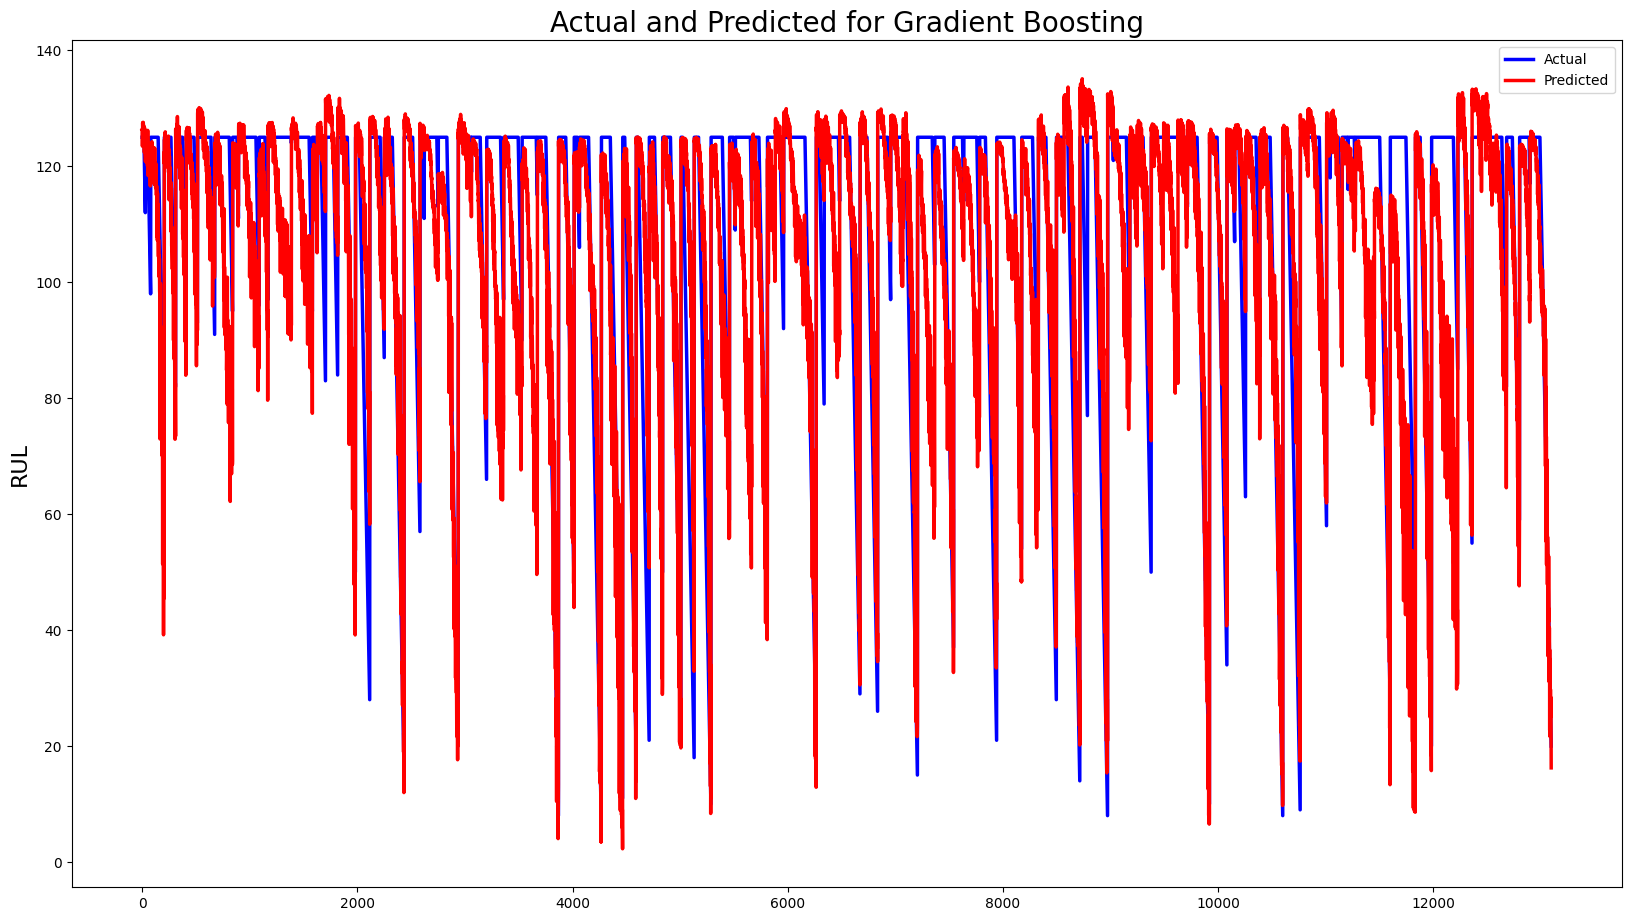

RMSE:  17.121604526894444
Industry score:  10737528.043888966


In [26]:
#Fitting
grad = GradientBoostingRegressor()
grad.fit(X_train,y_train)

#Prediction
y_pred_grad = grad.predict(X_test)

#Evalutation
mse_grad = mean_squared_error(y_test, y_pred_grad)
rmse_grad = mse_grad ** 0.5
assym = assym_score(y_test, y_pred_grad)
acc_grad = round(grad.score(X_train,y_train),2)*100

#Plotting
actual_vs_predicted('Gradient Boosting', y_test, y_pred_grad)

#Results
#Results
print("RMSE: ", rmse_grad)
print("Industry score: ", assym)

### Hyperparameter tuning for Gradient-Boosting Regressor

Parameters to tune:
* learning_rate -> controls the contribution of each tree in the ensemble
* n_estimators -> number of boosting stages to perform
* max_depth -> maximum depth of the individual regression estimators
* min_samples_split -> minimum number of samples required to split an internal node
* min_samples_leaf -> minimum number of samples required to be at a leaf node 
* max_features -> number of features to consider when looking for the best split

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [28]:
# Parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [int(x) for x in np.linspace(10,100,10)],
    'max_depth': [int(x) for x in np.linspace(5,30,6)],
    'min_samples_split': [2,5,10,15,100],
    'min_samples_leaf': [1,2,5,10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'subsample': [0.6, 0.8, 1.0]
}

In [29]:
# Fitting
hyperparameter_tuned_GB = RandomizedSearchCV(estimator=grad,param_distributions=param_grid)
hyperparameter_tuned_GB.fit(X_train,y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100],
                                        'subsample': [0.6, 0.8, 1.0]})

In [30]:
print('The parameters which are considered to be the best for the model are : ')
hyperparameter_tuned_GB.best_params_

The parameters which are considered to be the best for the model are : 


{'subsample': 1.0,
 'n_estimators': 60,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 5,
 'learning_rate': 0.1}

In [31]:
# Prediction
y_pred_grad_tuned = hyperparameter_tuned_GB.predict(X_test)

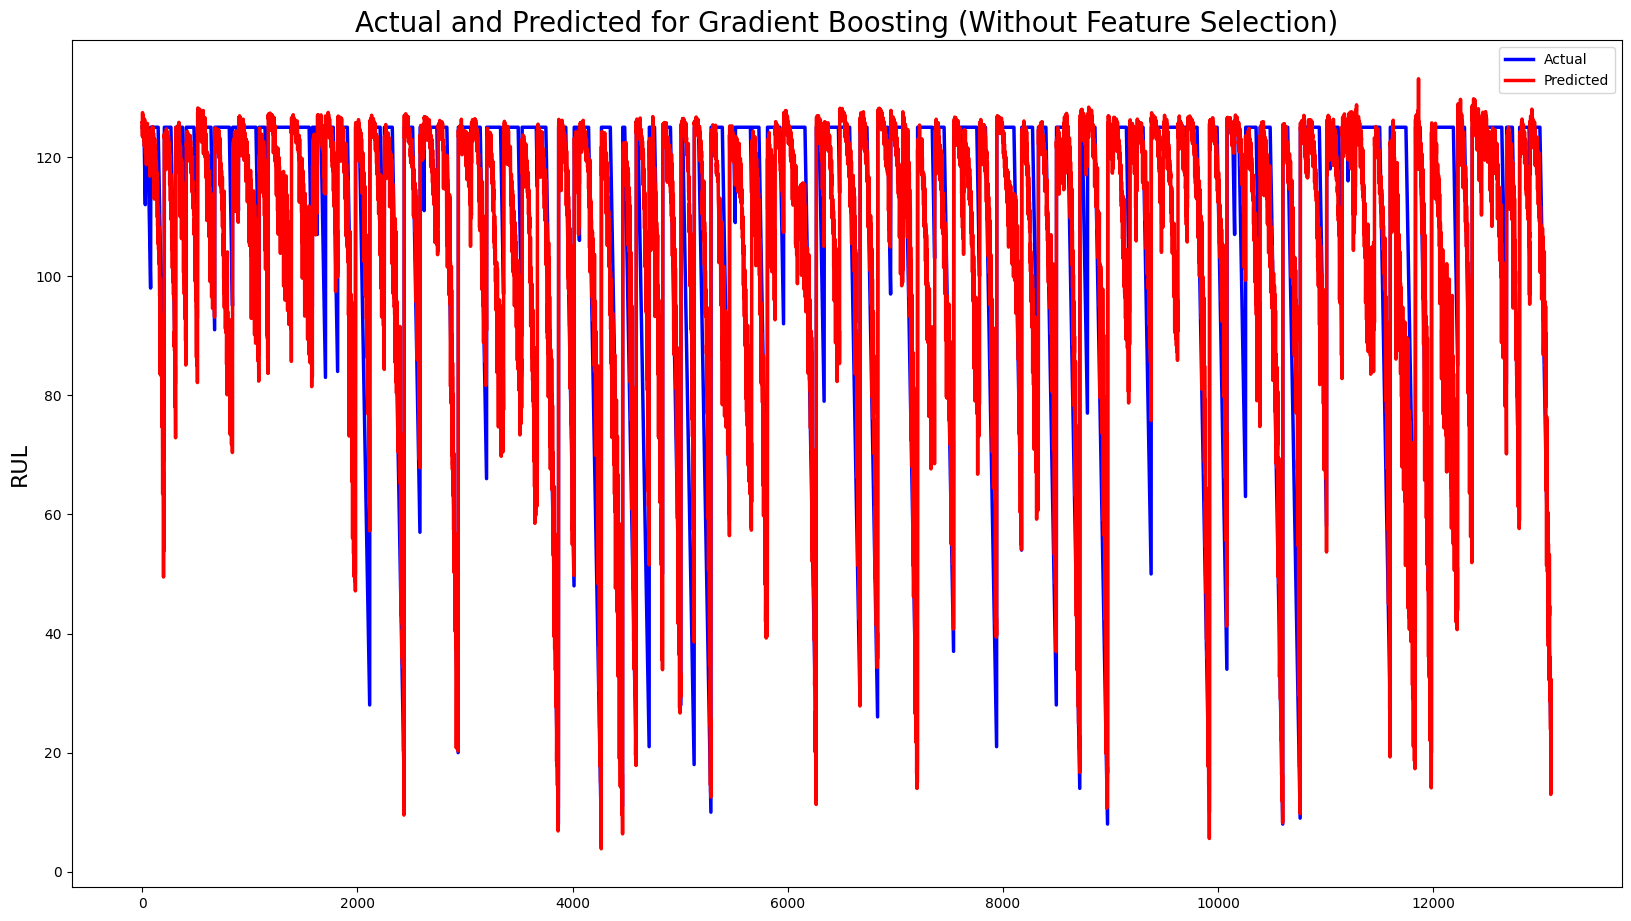

RMSE:  15.947652771639675
Industry score:  8513442.34258472


In [32]:
#Evaluation
mse_grad = mean_squared_error(y_test, y_pred_grad_tuned)
rmse_grad = mse_grad ** 0.5
assym = assym_score(y_test, y_pred_grad_tuned)

#Plotting
actual_vs_predicted('Gradient Boosting (Without Feature Selection)', y_test, y_pred_grad_tuned)

#Results
print("RMSE: ", rmse_grad)
print("Industry score: ", assym)

In [35]:
print(len(y_pred_grad_tuned))

13096


In [36]:
test_data['Predicted RUL'] = y_pred_grad_tuned

test_data.to_csv('test_data_with_predictions.csv', index=False)

## Convolutional Neural Network

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [92]:
# model = Sequential()

def create_CNN():
    model = Sequential()
    # Input layer
    model.add(Conv1D(14, 4, activation='sigmoid', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(2, strides=2))
    
    # Hidden layers
    model.add(Conv1D(8, 2, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    model.add(Conv1D(8, 12, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    model.add(Conv1D(6, 6, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    
    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    
    # Output layer
    model.add(Dense(1))
    return model

model = create_CNN()

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size = 10, epochs = 30)

Epoch 1/30
2064/2064 [==============================] - 2s 647us/step - loss: 8857.3184
Epoch 2/30
2064/2064 [==============================] - 1s 611us/step - loss: 8153.4287
Epoch 3/30
2064/2064 [==============================] - 1s 602us/step - loss: 7210.2588
Epoch 4/30
2064/2064 [==============================] - 1s 623us/step - loss: 6282.9609
Epoch 5/30
2064/2064 [==============================] - 1s 604us/step - loss: 5525.8403
Epoch 6/30
2064/2064 [==============================] - 1s 596us/step - loss: 4847.7617
Epoch 7/30
2064/2064 [==============================] - 1s 595us/step - loss: 4243.7827
Epoch 8/30
2064/2064 [==============================] - 1s 596us/step - loss: 3710.4404
Epoch 9/30
2064/2064 [==============================] - 1s 597us/step - loss: 3247.1284
Epoch 10/30
2064/2064 [==============================] - 1s 597us/step - loss: 2852.7751
Epoch 11/30
2064/2064 [==============================] - 1s 597us/step - loss: 2527.5276
Epoch 12/30
2064/2064 [=======

410/410 [==============================] - 0s 475us/step - loss: 1249.5437


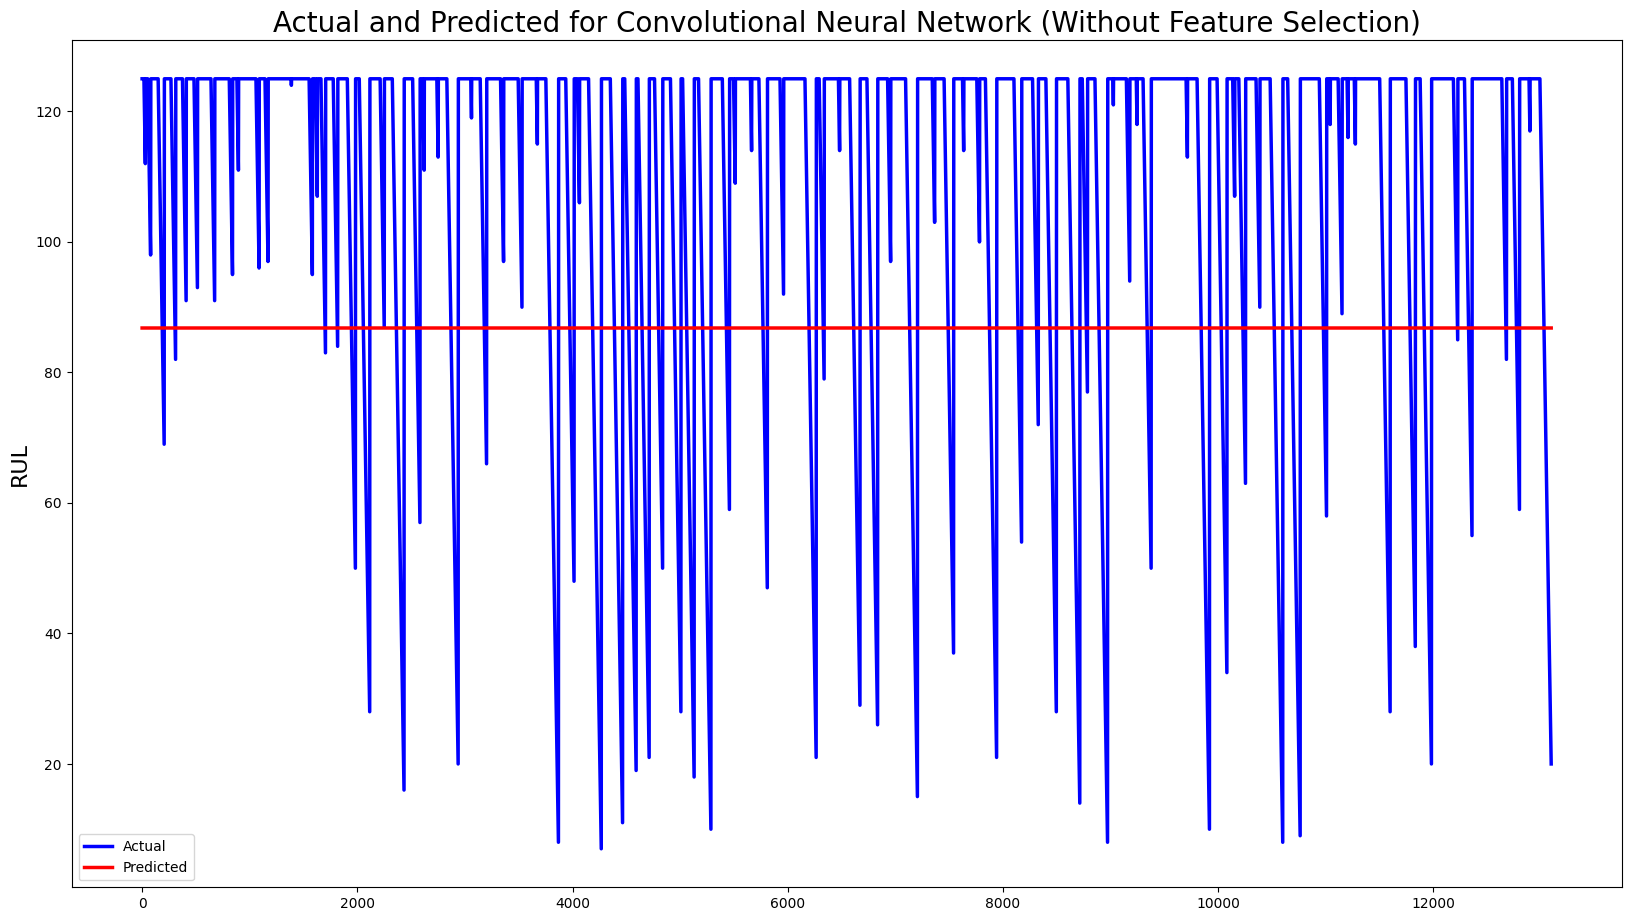

RMSE:  35.34889384456344
Loss:  1249.543701171875
Industry score:  35.981829958663596


In [93]:
# Prediction 
y_pred_cnn = model.predict(X_test)

# Evaluation
mse_cnn = mean_squared_error(y_test,y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
loss = model.evaluate(X_test, y_test)
assym = assym_score(y_test, y_pred_cnn)

#Plotting
actual_vs_predicted('Convolutional Neural Network (Without Feature Selection)', y_test, y_pred_cnn)

#Results
print("RMSE: ", rmse_cnn)
print("Loss: ", loss)
print("Industry score: ", assym)

### Hyperparameter tuning for CNN

Parameters to tune:
* batch_size: 8, 16, 32, 64, 128
* epochs: 10, 30, 75
* optimizer: adam or sgd?

In [94]:
results_df = pd.DataFrame(columns=['Batch Size', 'Optimizer', 'Epochs', 'RMSE', 'Assymetric Loss'])
batch_sizes = [8, 16, 32, 64, 128]
epochs = [10, 30, 75]
optimizers = ['adam', 'sgd']

for batches in batch_sizes:
    for num_epochs in epochs:
        for opt in optimizers: 
            model = create_CNN()
            model.compile(optimizer=opt, loss='mean_squared_error')
            model.fit(X_train, y_train, batch_size = batches, epochs = num_epochs)
            y_pred_cnn = model.predict(X_test)
            mse_cnn = mean_squared_error(y_test,y_pred_cnn)
            rmse_cnn = mse_cnn ** 0.5
            assym = assym_score(y_test, y_pred_cnn)
            print(f"Batch size: {batches}, Optimizer: {opt}, Epochs: {num_epochs}")
            print("RMSE: ", rmse_cnn)
            print("Industry score: ", assym)
            results_df.loc[len(results_df.index)] = [batches, opt, num_epochs, rmse_cnn, assym]

Epoch 1/10
2579/2579 [==============================] - 2s 629us/step - loss: 8821.2520
Epoch 2/10
2579/2579 [==============================] - 2s 601us/step - loss: 7962.7305
Epoch 3/10
2579/2579 [==============================] - 2s 611us/step - loss: 6704.4141
Epoch 4/10
2579/2579 [==============================] - 2s 584us/step - loss: 5713.9097
Epoch 5/10
2579/2579 [==============================] - 1s 581us/step - loss: 4857.6753
Epoch 6/10
2579/2579 [==============================] - 1s 577us/step - loss: 4115.9551
Epoch 7/10
2579/2579 [==============================] - 1s 575us/step - loss: 3485.3398
Epoch 8/10
2579/2579 [==============================] - 1s 573us/step - loss: 2964.6306
Epoch 9/10
2579/2579 [==============================] - 1s 578us/step - loss: 2549.1401
Epoch 10/10
410/410 [==============================] - 0s 439us/step
Batch size: 8, Optimizer: adam, Epochs: 10
RMSE:  49.72419532777067
Industry score:  210.6580436467595
Epoch 1/10
2579/2579 [==============

In [95]:
results_df

,Batch Size,Optimizer,Epochs,RMSE,Assymetric Loss
0,8,adam,10,49.724195,210.658044
1,8,sgd,10,34.476325,32.661165
2,8,adam,30,35.353872,36.002284
3,8,sgd,30,36.953514,43.501501
4,8,adam,75,35.344590,35.964158
5,8,sgd,75,34.679338,33.387295
6,16,adam,10,74.758519,3495.342038
7,16,sgd,10,34.480484,32.675801
8,16,adam,30,36.147754,39.489107
9,16,sgd,30,35.924509,38.462804


The top performing hyperparameters were
* batch_size = 64
* optimizer = sgd
* epochs = 75

Epoch 1/75
323/323 [==============================] - 1s 1ms/step - loss: 1959.4540
Epoch 2/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.4366
Epoch 3/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.7332
Epoch 4/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.6383
Epoch 5/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.7717
Epoch 6/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.7609
Epoch 7/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.1926
Epoch 8/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.4854
Epoch 9/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.4287
Epoch 10/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.8278
Epoch 11/75
323/323 [==============================] - 0s 1ms/step - loss: 1737.5764
Epoch 12/75
323/323 [==============================] - 0s 1ms/step - loss:

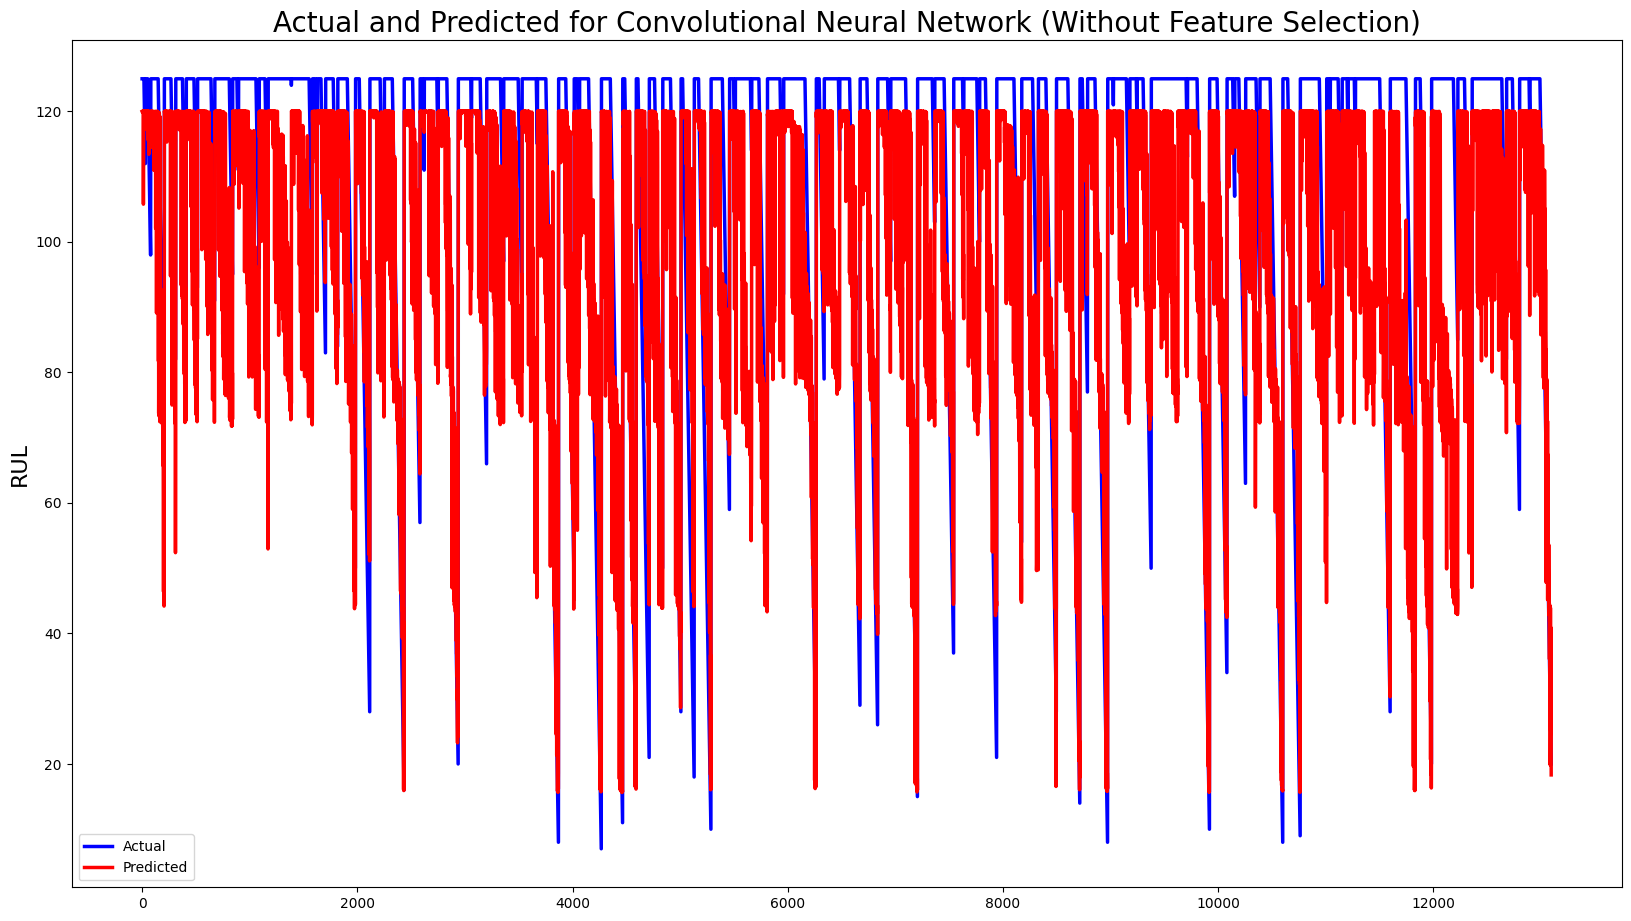

Batch size: 128, Optimizer: sgd, Epochs: 75
RMSE:  19.770165857364127
Industry score:  14.18229841611363


In [98]:
model = create_CNN()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 64, epochs = 75)
y_pred_cnn = model.predict(X_test)

actual_vs_predicted('Convolutional Neural Network (Without Feature Selection)', y_test, y_pred_cnn)

mse_cnn = mean_squared_error(y_test,y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
assym = assym_score(y_test, y_pred_cnn)
print(f"Batch size: {batches}, Optimizer: {opt}, Epochs: {num_epochs}")
print("RMSE: ", rmse_cnn)
print("Industry score: ", assym)

## Feature Selection

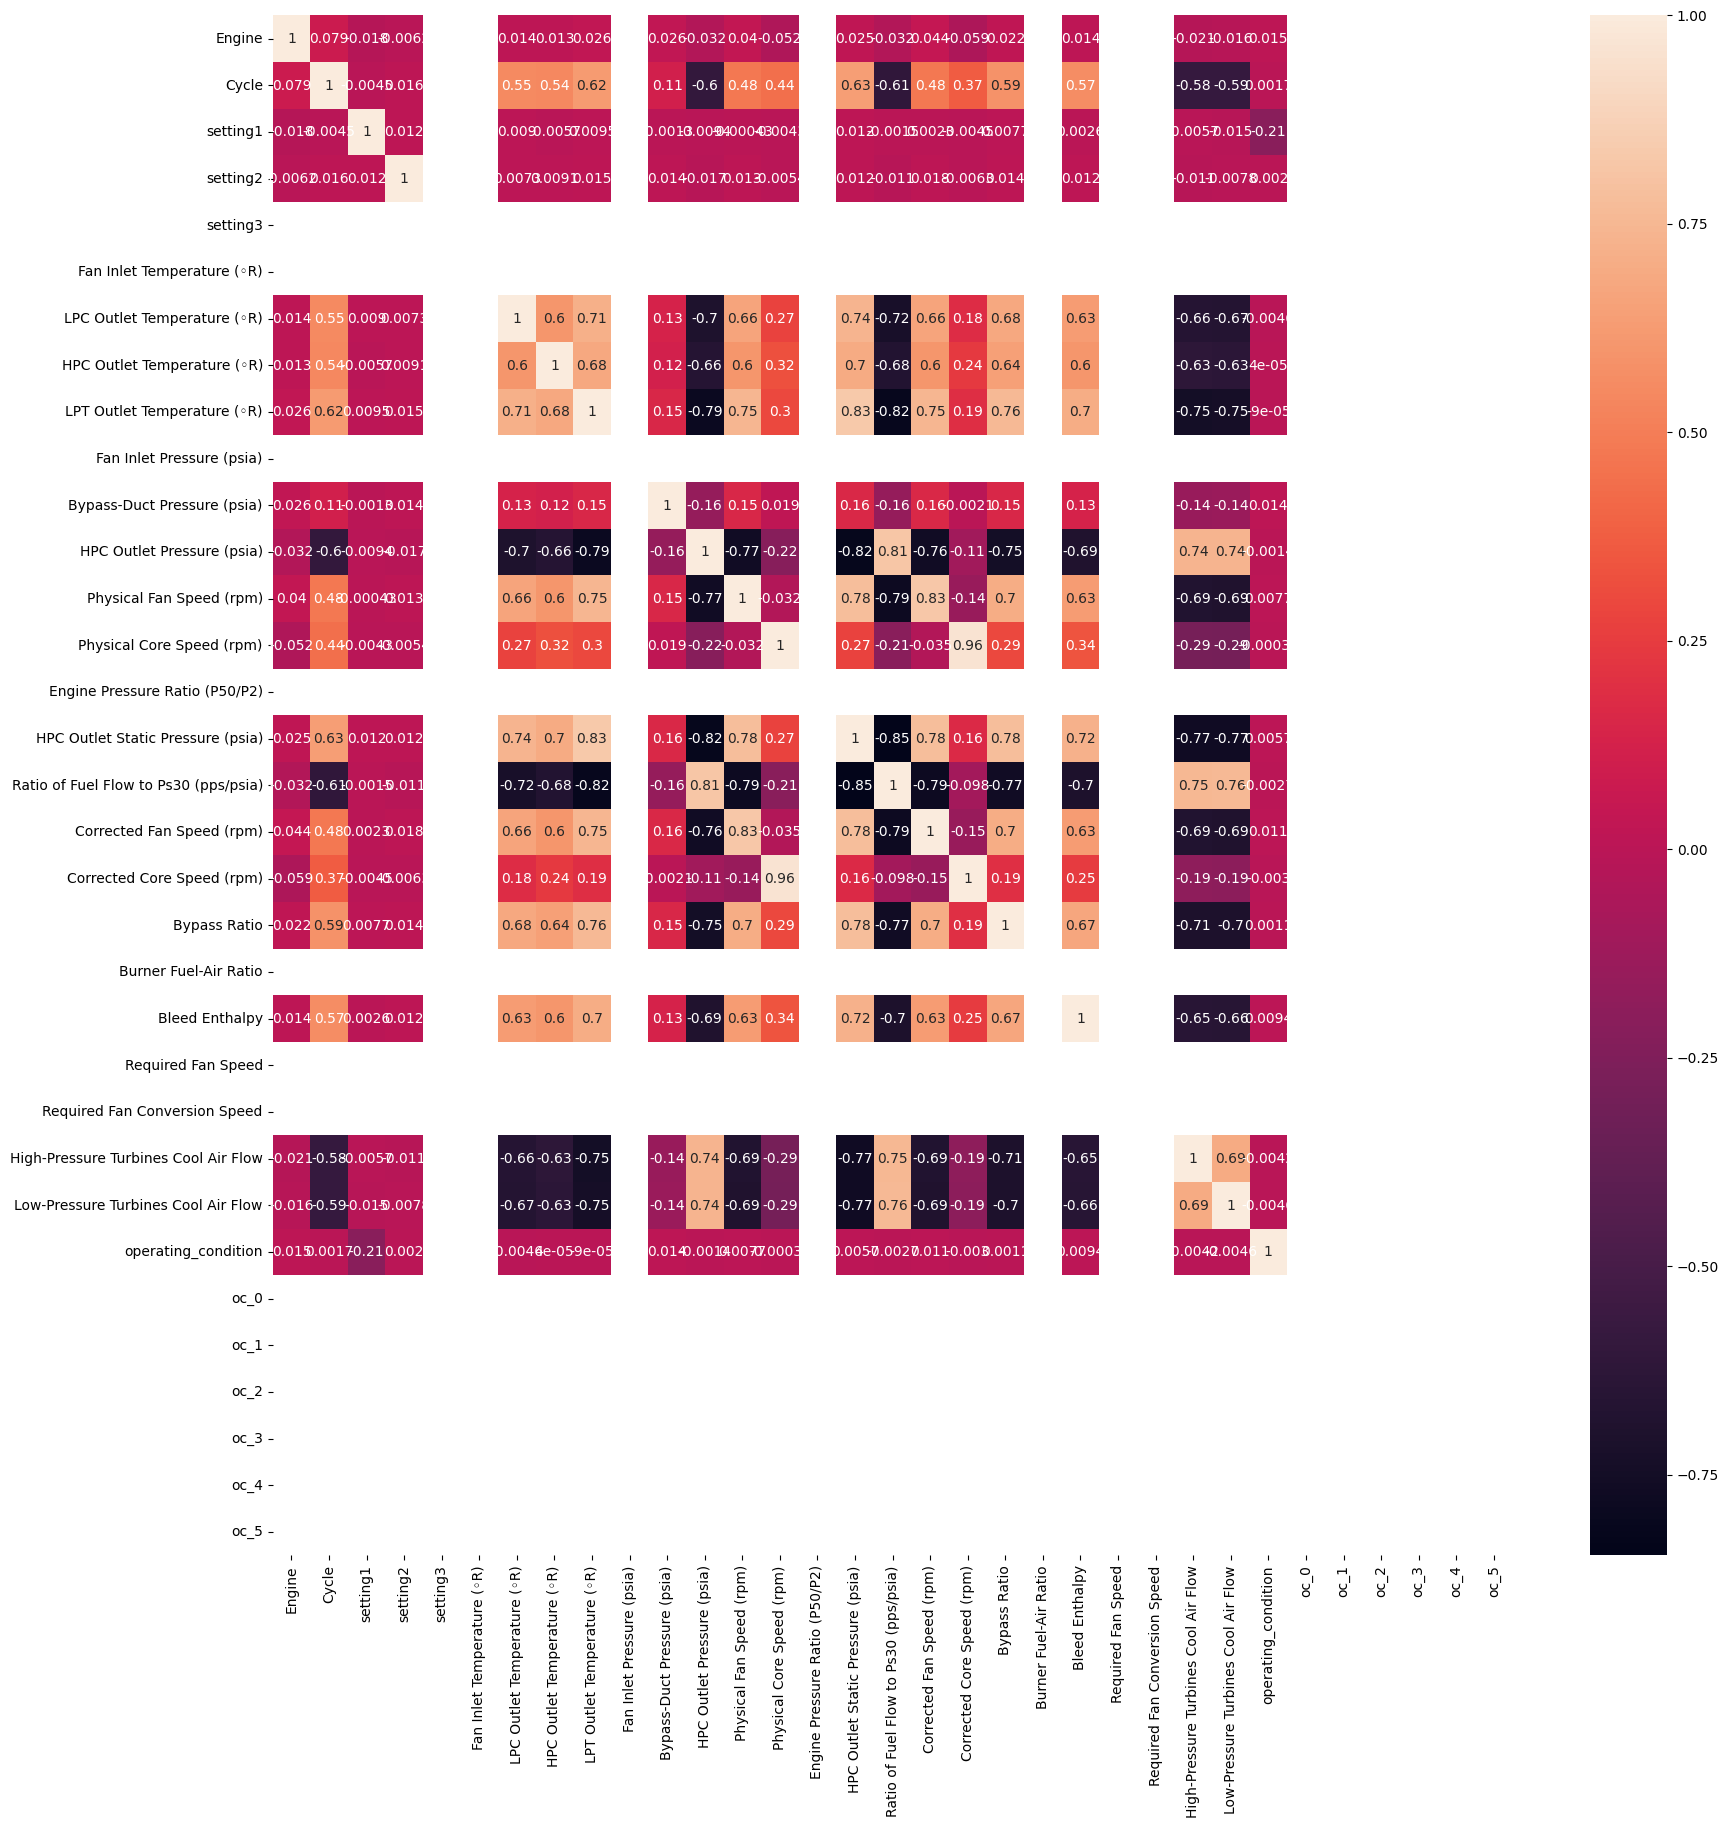

In [99]:
#Finding the correlated features using heatmap
plt.figure(figsize=(20,20))
sns.heatmap(train_data.drop('RUL',axis=1).corr(),cbar=True,annot=True,xticklabels=train_data.columns.drop('RUL'))
plt.savefig('Correlation Heatmap.png')
plt.show()

In [106]:
corr=train_data.corr()
train_relevant_features = corr[abs(corr['RUL'])>=0.5]

imp_features=train_relevant_features.index[1:]
print(f'These are the important features that we are going to consider: {imp_features}')

These are the important features that we are going to consider: Index(['LPC Outlet Temperature (◦R)', 'HPC Outlet Temperature (◦R)',
       'LPT Outlet Temperature (◦R)', 'HPC Outlet Pressure (psia)',
       'Physical Fan Speed (rpm)', 'HPC Outlet Static Pressure (psia)',
       'Ratio of Fuel Flow to Ps30 (pps/psia)', 'Corrected Fan Speed (rpm)',
       'Bypass Ratio', 'Bleed Enthalpy',
       'High-Pressure Turbines Cool Air Flow',
       'Low-Pressure Turbines Cool Air Flow', 'RUL'],
      dtype='object')


In [107]:
corr_train_data = train_data[imp_features]
corr_test_data = test_data[imp_features]

In [108]:
corr_train_data

,LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Bypass Ratio,Bleed Enthalpy,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,RUL
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,125.0
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,125.0
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,125.0
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,125.0
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4.0
20627,643.54,1604.50,1433.58,550.86,2388.23,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3.0
20628,643.42,1602.46,1428.18,550.94,2388.24,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2.0
20629,643.23,1605.26,1426.53,550.68,2388.25,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1.0


In [109]:
corr_test_data

,LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Bypass Ratio,Bleed Enthalpy,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow,RUL
0,643.02,1585.29,1398.21,553.90,2388.04,47.20,521.72,2388.03,8.4052,392,38.86,23.3735,125.0
1,641.71,1588.45,1395.42,554.85,2388.01,47.50,522.16,2388.06,8.3803,393,39.02,23.3916,125.0
2,642.46,1586.94,1401.34,554.11,2388.05,47.50,521.97,2388.03,8.4441,393,39.08,23.4166,125.0
3,642.44,1584.12,1406.42,554.07,2388.03,47.28,521.38,2388.05,8.3917,391,39.00,23.3737,125.0
4,642.51,1587.19,1401.92,554.16,2388.01,47.31,522.15,2388.03,8.4031,390,38.99,23.4130,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,643.24,1599.45,1415.79,553.41,2388.02,47.69,520.69,2388.00,8.4715,394,38.65,23.1974,24.0
13092,643.22,1595.69,1422.05,553.22,2388.05,47.60,521.05,2388.09,8.4512,395,38.57,23.2771,23.0
13093,643.44,1593.15,1406.82,553.04,2388.11,47.57,521.18,2388.04,8.4569,395,38.62,23.2051,22.0
13094,643.26,1594.99,1419.36,553.37,2388.07,47.61,521.33,2388.08,8.4711,395,38.66,23.2699,21.0


In [110]:
# seperate training and testing data
X_train=corr_train_data.drop('RUL',axis=1)
y_train=corr_train_data[['RUL']]

In [111]:
X_train.head()

,LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Bypass Ratio,Bleed Enthalpy,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044


In [112]:
y_train

,RUL
0,125.0
1,125.0
2,125.0
3,125.0
4,125.0
...,...
20626,4.0
20627,3.0
20628,2.0
20629,1.0


In [113]:
X_test=corr_test_data.drop('RUL',axis=1)
y_test=corr_test_data[['RUL']]

In [114]:
X_test

,LPC Outlet Temperature (◦R),HPC Outlet Temperature (◦R),LPT Outlet Temperature (◦R),HPC Outlet Pressure (psia),Physical Fan Speed (rpm),HPC Outlet Static Pressure (psia),Ratio of Fuel Flow to Ps30 (pps/psia),Corrected Fan Speed (rpm),Bypass Ratio,Bleed Enthalpy,High-Pressure Turbines Cool Air Flow,Low-Pressure Turbines Cool Air Flow
0,643.02,1585.29,1398.21,553.90,2388.04,47.20,521.72,2388.03,8.4052,392,38.86,23.3735
1,641.71,1588.45,1395.42,554.85,2388.01,47.50,522.16,2388.06,8.3803,393,39.02,23.3916
2,642.46,1586.94,1401.34,554.11,2388.05,47.50,521.97,2388.03,8.4441,393,39.08,23.4166
3,642.44,1584.12,1406.42,554.07,2388.03,47.28,521.38,2388.05,8.3917,391,39.00,23.3737
4,642.51,1587.19,1401.92,554.16,2388.01,47.31,522.15,2388.03,8.4031,390,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...
13091,643.24,1599.45,1415.79,553.41,2388.02,47.69,520.69,2388.00,8.4715,394,38.65,23.1974
13092,643.22,1595.69,1422.05,553.22,2388.05,47.60,521.05,2388.09,8.4512,395,38.57,23.2771
13093,643.44,1593.15,1406.82,553.04,2388.11,47.57,521.18,2388.04,8.4569,395,38.62,23.2051
13094,643.26,1594.99,1419.36,553.37,2388.07,47.61,521.33,2388.08,8.4711,395,38.66,23.2699


In [115]:
y_test

,RUL
0,125.0
1,125.0
2,125.0
3,125.0
4,125.0
...,...
13091,24.0
13092,23.0
13093,22.0
13094,21.0


In [116]:
print(f'The shape of the training data : {X_train.shape} , {y_train.shape}')
print(f'The shape of the testing data : {X_test.shape} , {y_test.shape}')

The shape of the training data : (20631, 12) , (20631, 1)
The shape of the testing data : (13096, 12) , (13096, 1)


#### Normalization

In [117]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Gradient Boosting over Feature Selected Dataset

In [118]:
#Fitting
grad = GradientBoostingRegressor()
grad.fit(X_train,y_train)

GradientBoostingRegressor()

In [119]:
# Parameter grid
param_grid_GBT = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [int(x) for x in np.linspace(10,100,10)],
    'max_depth': [int(x) for x in np.linspace(5,30,6)],
    'min_samples_split': [2,5,10,15,100],
    'min_samples_leaf': [1,2,5,10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'subsample': [0.6, 0.8, 1.0]
}

In [120]:
# Fitting
hyperparameter_tuned_GBT = RandomizedSearchCV(estimator=grad,param_distributions=param_grid_GBT)

In [121]:
hyperparameter_tuned_GBT.fit(X_train,y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100],
                                        'subsample': [0.6, 0.8, 1.0]})

In [122]:
print('The parameters which are considered to be the best for the model are : ')
hyperparameter_tuned_GBT.best_params_

The parameters which are considered to be the best for the model are : 


{'subsample': 0.6,
 'n_estimators': 80,
 'min_samples_split': 15,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 5,
 'learning_rate': 0.1}

In [123]:
# Prediction
y_pred_grad_tuned = hyperparameter_tuned_GBT.predict(X_test)

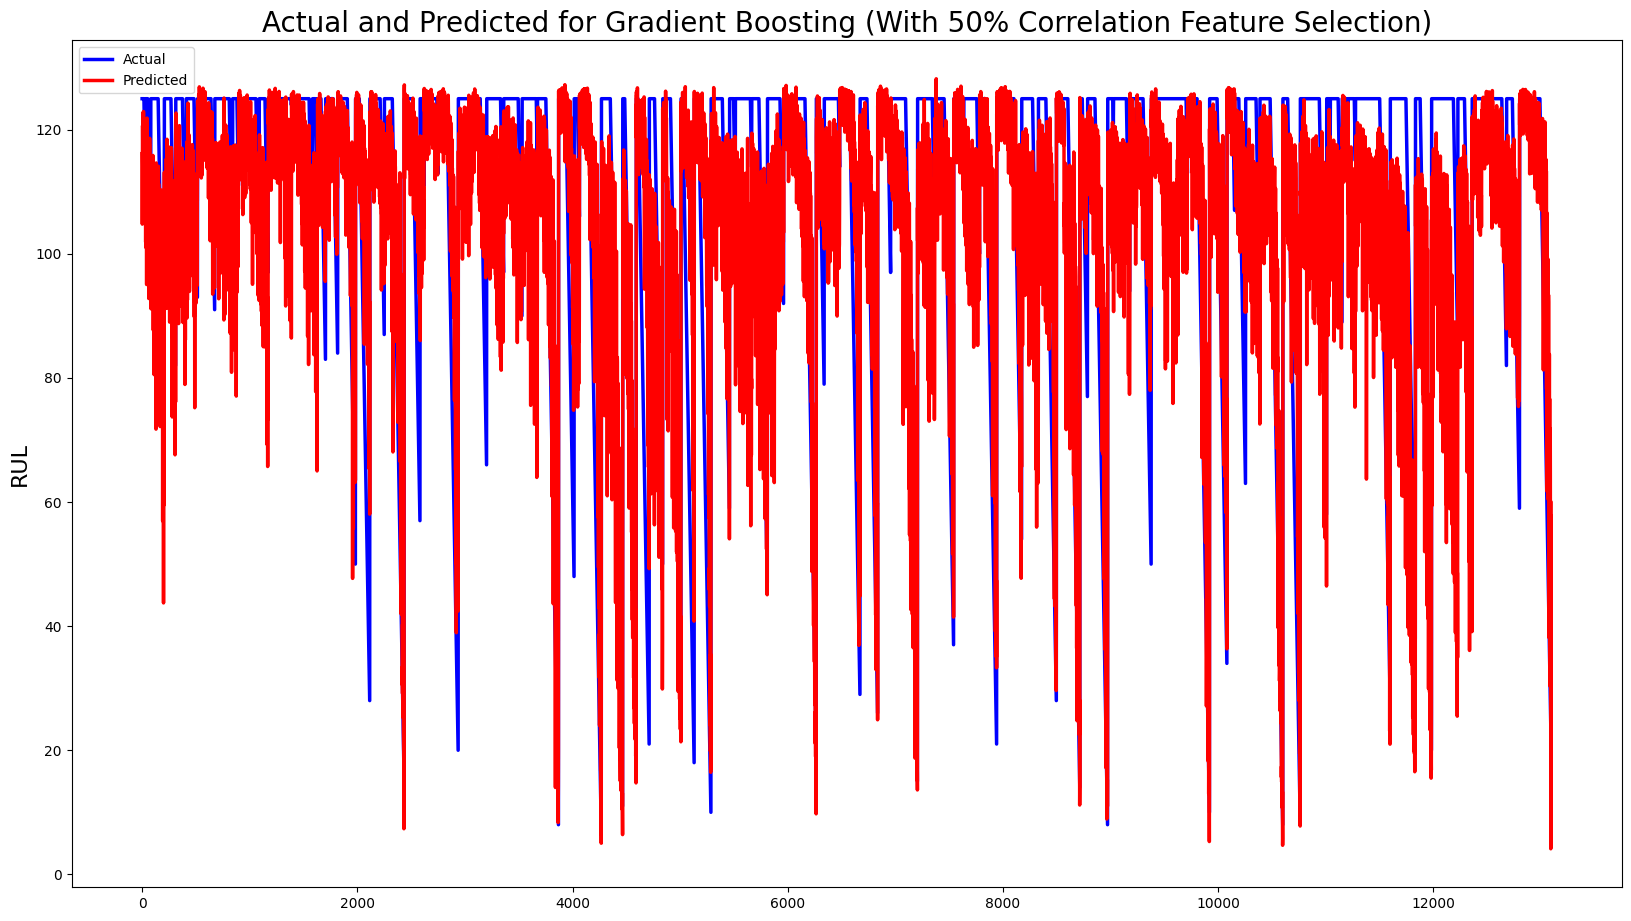

RMSE:  19.832904092841353
Industry score:  8626128.12149103


In [124]:
#Evaluation
mse_grad = mean_squared_error(y_test,y_pred_grad_tuned)
rmse_grad = mse_grad ** 0.5
assym = assym_score(y_test, y_pred_grad_tuned)

#Plotting
actual_vs_predicted('Gradient Boosting (With 50% Correlation Feature Selection)', y_test, y_pred_grad_tuned)

#Results
print("RMSE: ", rmse_grad)
print("Industry score: ", assym)

### CNN over feature-selected dataset

In [126]:
def create_CNN():
    model = Sequential()
    # Input layer
    model.add(Conv1D(14, 4, activation='sigmoid', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(2, strides=2))
    
    # Hidden layers
    model.add(Conv1D(8, 2, activation='sigmoid', padding='same'))
    #model.add(MaxPooling1D(2, strides=2))
    model.add(Conv1D(8, 12, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    model.add(Conv1D(6, 6, activation='sigmoid', padding='same'))
    model.add(MaxPooling1D(2, strides=2))
    
    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    
    # Output layer
    model.add(Dense(1))
    return model

In [128]:
results_df = pd.DataFrame(columns=['Batch Size', 'Optimizer', 'Epochs', 'RMSE', 'Assymetric Loss'])
batch_sizes = [8, 16, 32, 64, 128]
epochs = [10, 30, 75]
optimizers = ['adam', 'sgd']

for batches in batch_sizes:
    for num_epochs in epochs:
        for opt in optimizers: 
            model = create_CNN()
            model.compile(optimizer=opt, loss='mean_squared_error')
            model.fit(X_train, y_train, batch_size = batches, epochs = num_epochs)
            y_pred_cnn = model.predict(X_test)
            mse_cnn = mean_squared_error(y_test, y_pred_cnn)
            rmse_cnn = mse_cnn ** 0.5
            assym = assym_score(y_test, y_pred_cnn)
            print(f"Batch size: {batches}, Optimizer: {opt}, Epochs: {num_epochs}")
            print("RMSE: ", rmse_cnn)
            print("Industry score: ", assym)
            #df.loc[len(df)] = [4, 'd']
            results_df.loc[len(results_df.index)] = [batches, opt, num_epochs, rmse_cnn, assym]

Epoch 1/10
2579/2579 [==============================] - 2s 565us/step - loss: 8811.3682
Epoch 2/10
2579/2579 [==============================] - 1s 558us/step - loss: 7978.4331
Epoch 3/10
2579/2579 [==============================] - 1s 546us/step - loss: 6958.4575
Epoch 4/10
2579/2579 [==============================] - 1s 541us/step - loss: 5851.0835
Epoch 5/10
2579/2579 [==============================] - 1s 540us/step - loss: 4975.2812
Epoch 6/10
2579/2579 [==============================] - 1s 552us/step - loss: 4216.6133
Epoch 7/10
2579/2579 [==============================] - 1s 553us/step - loss: 3569.5471
Epoch 8/10
2579/2579 [==============================] - 1s 545us/step - loss: 3032.5549
Epoch 9/10
2579/2579 [==============================] - 1s 536us/step - loss: 2602.3164
Epoch 10/10
410/410 [==============================] - 0s 350us/step
Batch size: 8, Optimizer: adam, Epochs: 10
RMSE:  50.403303282762806
Industry score:  228.3953152854859
Epoch 1/10
2579/2579 [=============

In [129]:
results_df

,Batch Size,Optimizer,Epochs,RMSE,Assymetric Loss
0,8,adam,10,50.403303,228.395315
1,8,sgd,10,34.551850,32.928046
2,8,adam,30,35.362280,36.036868
3,8,sgd,30,35.467264,36.472880
4,8,adam,75,35.333618,35.919172
5,8,sgd,75,36.906764,43.255198
6,16,adam,10,76.233988,4095.817705
7,16,sgd,10,34.208949,31.747329
8,16,adam,30,36.123036,39.373690
9,16,sgd,30,35.385424,36.132324


Epoch 1/75
323/323 [==============================] - 1s 837us/step - loss: 1998.1350
Epoch 2/75
323/323 [==============================] - 0s 775us/step - loss: 1737.8350
Epoch 3/75
323/323 [==============================] - 0s 741us/step - loss: 1737.3657
Epoch 4/75
323/323 [==============================] - 0s 749us/step - loss: 1737.3091
Epoch 5/75
323/323 [==============================] - 0s 771us/step - loss: 1737.6763
Epoch 6/75
323/323 [==============================] - 0s 758us/step - loss: 1737.4023
Epoch 7/75
323/323 [==============================] - 0s 743us/step - loss: 1737.8851
Epoch 8/75
323/323 [==============================] - 0s 741us/step - loss: 1737.3964
Epoch 9/75
323/323 [==============================] - 0s 737us/step - loss: 1737.6104
Epoch 10/75
323/323 [==============================] - 0s 732us/step - loss: 1737.4323
Epoch 11/75
323/323 [==============================] - 0s 741us/step - loss: 1737.4465
Epoch 12/75
323/323 [==============================]

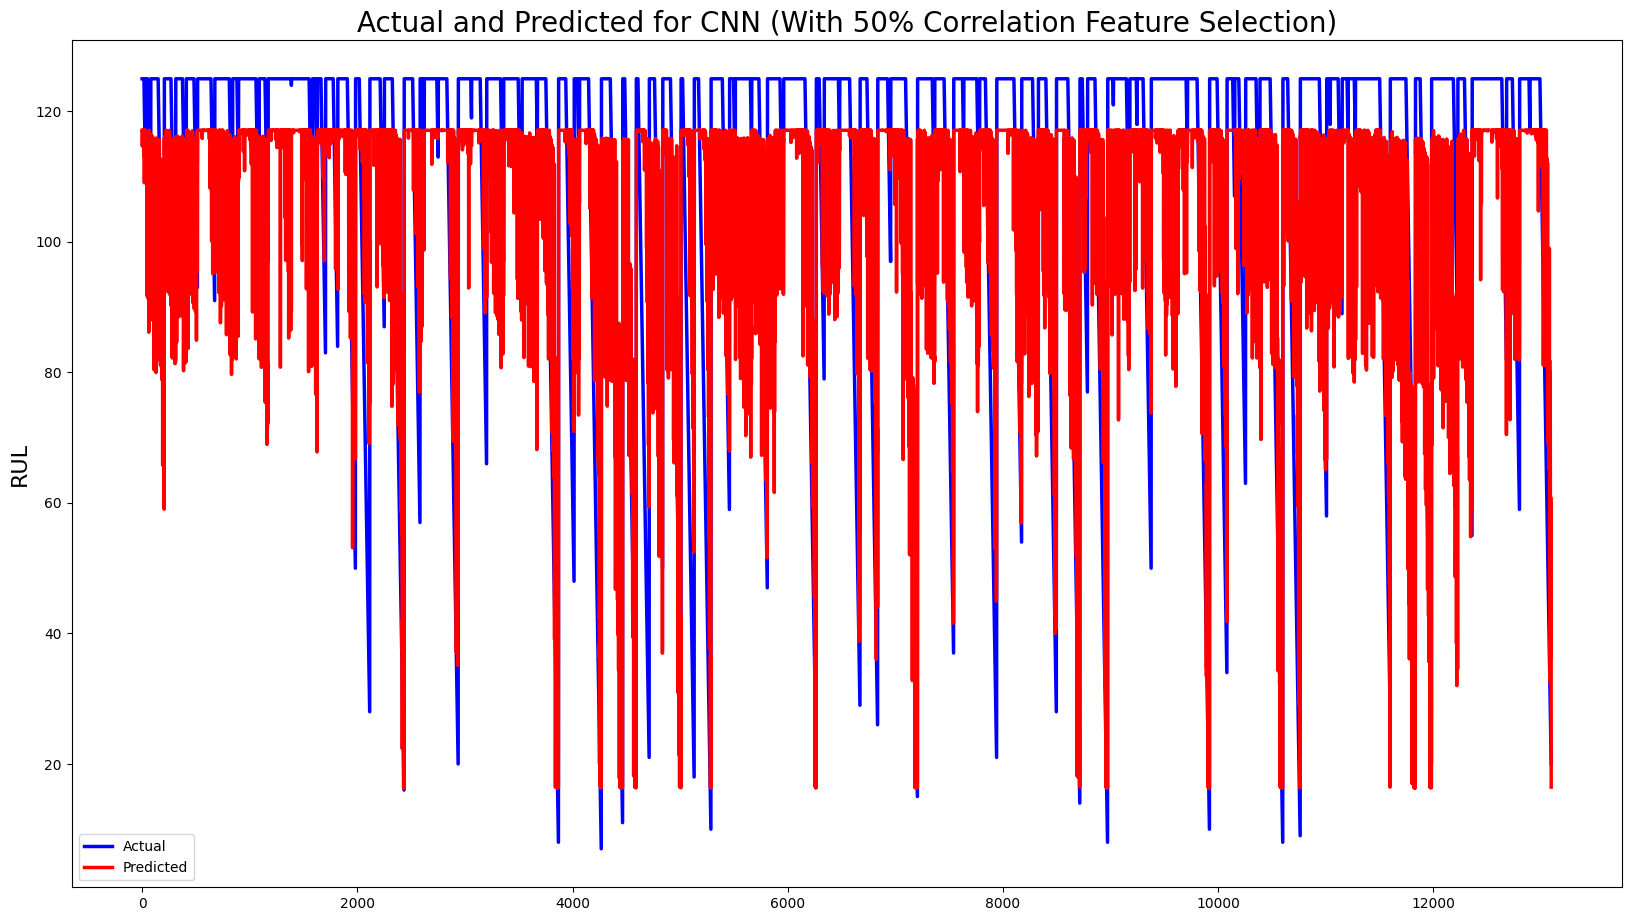

RMSE:  20.270846067157333
Industry score:  9.741127220359692


In [131]:
model = create_CNN()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 64, epochs = 75)
y_pred_cnn = model.predict(X_test)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
assym = assym_score(y_test, y_pred_cnn)
actual_vs_predicted('CNN (With 50% Correlation Feature Selection)', y_test, y_pred_cnn)
print("RMSE: ", rmse_cnn)
print("Industry score: ", assym)

Epoch 1/100
323/323 [==============================] - 1s 822us/step - loss: 1976.1561
Epoch 2/100
323/323 [==============================] - 0s 777us/step - loss: 1737.2794
Epoch 3/100
323/323 [==============================] - 0s 759us/step - loss: 1736.9686
Epoch 4/100
323/323 [==============================] - 0s 770us/step - loss: 1738.0573
Epoch 5/100
323/323 [==============================] - 0s 745us/step - loss: 1737.6069
Epoch 6/100
323/323 [==============================] - 0s 743us/step - loss: 1737.4469
Epoch 7/100
323/323 [==============================] - 0s 745us/step - loss: 1737.4642
Epoch 8/100
323/323 [==============================] - 0s 744us/step - loss: 1737.8917
Epoch 9/100
323/323 [==============================] - 0s 779us/step - loss: 1737.2092
Epoch 10/100
323/323 [==============================] - 0s 746us/step - loss: 1737.6110
Epoch 11/100
323/323 [==============================] - 0s 744us/step - loss: 1737.8179
Epoch 12/100
323/323 [===================

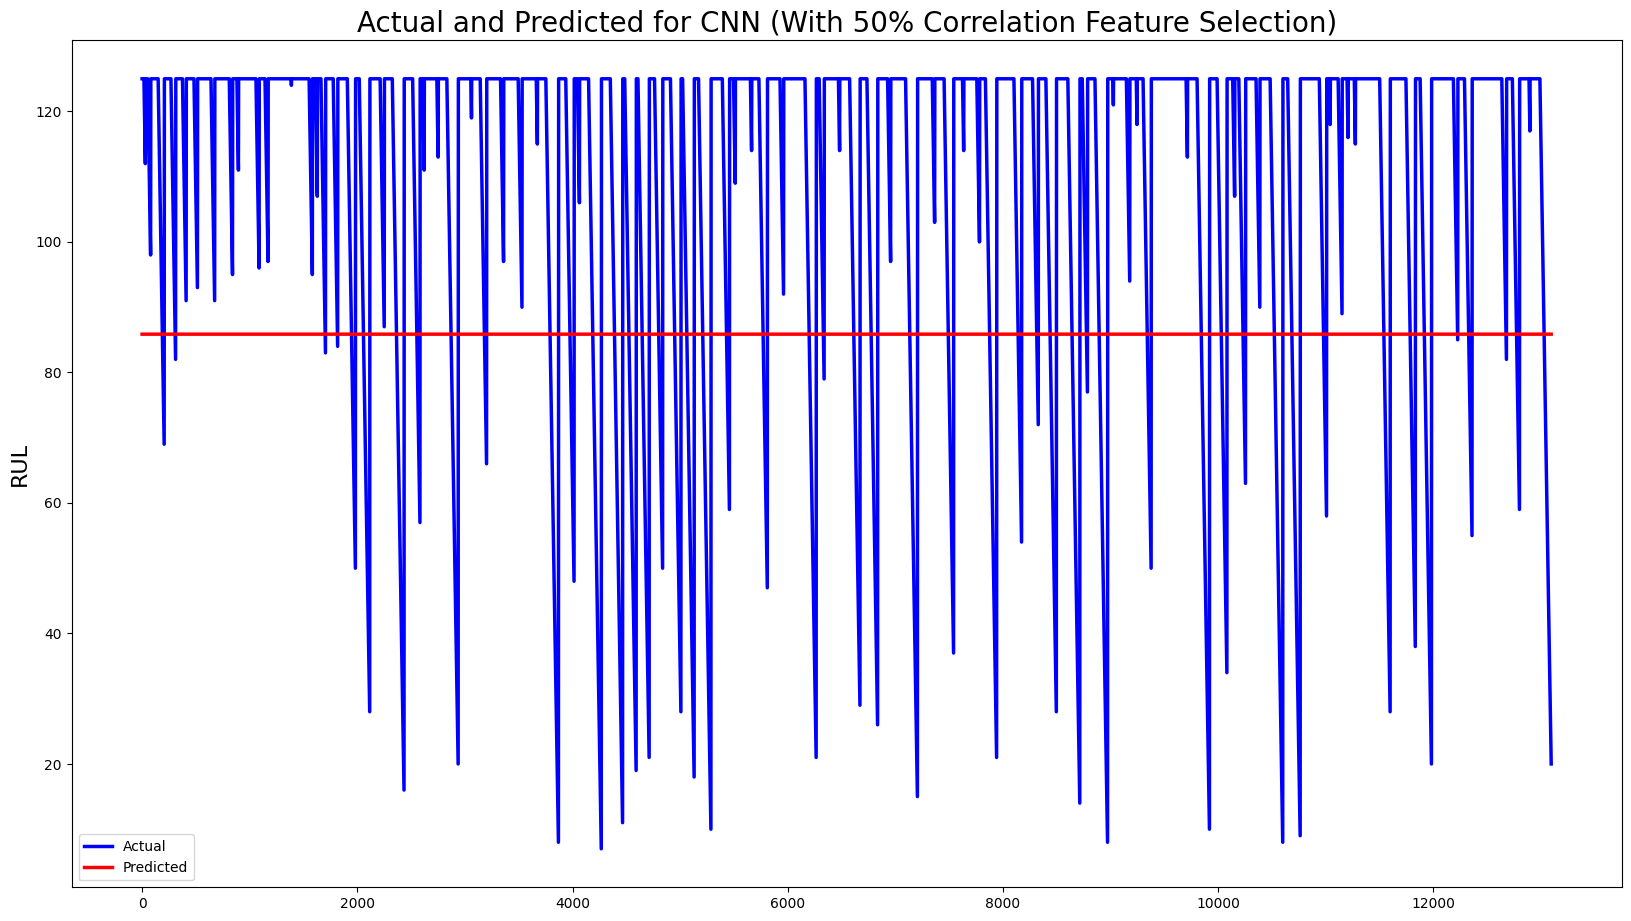

RMSE:  35.94802185920641
Industry score:  38.56919276120992


In [132]:
model = create_CNN()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 64, epochs = 75)
y_pred_cnn = model.predict(X_test)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
rmse_cnn = mse_cnn ** 0.5
assym = assym_score(y_test, y_pred_cnn)
actual_vs_predicted('CNN (With 50% Correlation Feature Selection)', y_test, y_pred_cnn)
print("RMSE: ", rmse_cnn)
print("Industry score: ", assym)